# 測試視窗

Can not find the correct cluster number: 2

2

means converge



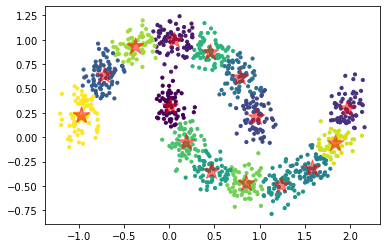

In [11]:
S,A,cd,aa =Clustering.k_multiple_means(X3,2,15,2)

plt.scatter(X3[:,0],X3[:,1],c=list(A),s=10)   
plt.scatter(aa[:,0],aa[:,1],s=300,c='red',marker='*',alpha=0.5,)    
  

# 參考文獻
作者 Github：https://github.com/CHLWR/KDD2019_K-Multiple-Means

# Import

In [10]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.sparse import csr_matrix
from scipy.sparse import spdiags
from scipy.sparse.csgraph import connected_components
from scipy import linalg
import numpy.matlib
import math

#產生測試 Data------------------------------------------------ 
two_moon=datasets.make_moons(n_samples=1000,noise=0.1)
X3=two_moon[0]

# KMM_Function
## **input:**
- x : Data matrix
- c : The number of cluster
- m : The number of subcluster
- k : The number of neighbor prototype
    
## **output:**
- lakmm : The cluster assignment for each point
- lamm : The sub-cluster assignment for each point
- A : Coordinates of the multiple means 

    

In [1]:
import numpy as np

class Clustering(object):
    
    def __init__(self): pass
    
    def k_multiple_means(x,c,m,k=5):
        
        iterTimes=1000             #迭代次數
        n=np.size(x,axis=0)        #共有幾筆資料
        dim=np.size(x,axis=1)      #每筆資料的維度
        opt_conv=1
            
        #connection probability matrix(initial)
        BiGraph = np.array(np.ones([n,m]))   
       
        #--------用k-means找出初始index--------
            
        KM=KMeans(n_clusters=m,init='random',random_state=6)
        KM.fit(x)
        StartIndex=list(KM.predict(x))                            #A_index : 紀錄 Data point 屬於哪個 Prototype

        A=meanIdex(x,StartIndex,m,BiGraph)
        lakmm,lamm,BiGraph,isCov=CSBG(x,c,A,k)
        print(k,end='\n\n')
        
        for count_iter in range(iterTimes):               
            
            if isCov:
                
                if opt_conv==1:
                    
                    StartIndex = lamm[0]
                    old_A=np.copy(A)  
                    A=meanIdex(x,StartIndex,m,BiGraph) 
                    
                    #--------判斷收斂--------
                    th=np.linalg.norm(A-old_A)                       #計算兩個prototype的距離
            
                    if th<np.spacing(1):                             #電腦區分兩個數的差的最小精度，當兩個數的差小於這個值，則電腦認為兩個數相等
                        
                        print('means converge\n')
                        return lakmm,lamm,BiGraph,A
                        

                lakmm,lamm,BiGraph,isCov=CSBG(x,c,A,k)
            else:
                BiGraph = np.array(np.ones([n,m])) 
                A=meanIdex(x,StartIndex,m,BiGraph)
                lakmm,lamm,BiGraph,isCov=CSBG(x,c,A,k)
            

        return lakmm,lamm,BiGraph,A

---
## Function : meanIdex 

### 功能 : 更新 A (Prototype 座標 ) ----------> 對應公式（5）

#### **(input)**
- **x**       : Data Point<br>
- **A_index** : 紀錄 Data point 屬於哪個 Prototype (Label值)<br>
- **m**       : sub-cluster(prototype)數量<br>
- **S**       : 連接機率矩陣<br>
    
#### **(return)**
- 更新後的矩陣 **A** (Prototype 座標)<br>

In [2]:
def meanIdex(x,A_index,m,S):

    A=np.zeros([m,2])
    n=np.size(x,axis=0)

    
    if len(np.unique(A_index))!=m:
        
        KM=KMeans(n_clusters=m,init='random',random_state=6)
        KM.fit(x)
        A_index = list(KM.predict(x))
        S = np.ones([n,m])

    for j in range(m):
            
            mu=0
            su=0
            for i in range(n):       
                
                if A_index[i]==j:
                   
                    mu=mu+(x[i]*S[i][j])
                    su=su+S[i][j]

                    
            A[j]=mu/su       
    
    return A

---
## Function : CSBG

### 功能 : 約束 Bigraph
#### !!!!k 不應該小於 c
#### **(input)**
- **x**       : Data Point<br>
- **c**       : The number of cluster<br>
- **A**       : Coordinates of the multiple means<br>

    
#### **(return)**
- lakmm : The cluster assignment for each point
- lamm : The sub-cluster assignment for each point
- bigraph : Bipartite graph (Data point and neighbor prototype)
- A : Coordinates of the multiple means 

In [3]:
def CSBG(x,c,A,k=5):
    
    n=np.size(x,axis=0)     #計算 Data point 數量
    m=np.size(A,axis=0)     #計算 Prototype 數量
    
    #從 Bigraph 看會比較清楚
    z,y,distX,k_index=ConstructA_NP(X3,A,k)      #預設 k=5，(Data Point 鄰近 k 個 Prototype) 頭到尾
    zT,yT,distXT,k_indexT=ConstructA_NP(A,X3,k)   #(Prototype 鄰近 k 個 Data Point) 尾到頭

    k_index=k_index.astype(int)
    k_indexT=k_indexT.astype(int)

    # 給定 lambda 值
    l = (y+yT)/2

    #求平均機率
    z0 = (z+zT.T)/2 

    NITER = 10 #迭代次數
    zr = 10e-5

    
    BiGraph,u,v,evc,D1,D2 = svd2uv(z0,c)

    u=np.mat(u)
    v=np.mat(v)
    D1=np.mat(D1)
    D2=np.mat(D2)


    if np.sum(evc[0:c]) > c*(1-zr):
        print('Error!!：The original graph has more than %d connected component Please set k larger'%c,end='\n\n')


    #求 Data Point 與 k 個鄰近 Prototype (距離) -------------------------- k_dist
    dxi = np.zeros([n,k])  
    for i in range(n):

        dxi[i,:] = distX[i][k_index[i]]

    #求 Prototype 與 k 個鄰近 Data Point (距離) --------------------------

    dxiT = np.zeros([m,k]) 
    for i in range(m):

        dxiT[i,:] = distXT[i][k_indexT[i]]


    Ater = 0    #判斷提前跳出迭代

    for ite in range(NITER):
        u1 = D1 * u              #X 
        v1 = D2 * v              #Y


        dist=np.zeros([n,m])

        for i in range(m):
            in_c = v1[i]

            dist[:,i] = np.linalg.norm(u1-in_c,ord=2,axis=1)
        #-------------------------------------------(data point --> prototype)    
        tmp1 = np.zeros([n,k])

        for i in range(n):

            dfi = dist[i][k_index[i]]
            ad = -(dxi[i,:]+ l*dfi)/(2*y)             #這裏算出的機率並不能對應真實值，對應公式(20)
            tmp1[i,:] = EprojSimplex_new(ad)

        count=[]

        count=np.matlib.repmat(np.arange(n), 1, k) #產生 k次 1維 (0~n-1)數值
        k_index_1=k_index.reshape(1,n*k)
        tmp=tmp1.reshape(1,n*k)
        Z = csr_matrix((tmp[0], (count[0], k_index_1[0])),shape=(n, m)).toarray()

        #-------------------------------------------(prototype --> data point)
        tmp2 = np.zeros([m,k])

        for i in range(m):

            dfiT = dist.T[i][k_indexT[i]]   

            ad = -(dxiT[i] + l*dfiT)/(2*y)             #這裏算出的機率並不能對應真實值，對應公式(20)

            tmp2[i,:] = EprojSimplex_new(ad)

        count=[]
        count=np.matlib.repmat(np.arange(m), 1, k) #產生 k次 1維 (0~m-1)數值
        k_index_2=k_indexT.reshape(1,m*k)
        tmp=tmp2.reshape(1,m*k)
        ZT = csr_matrix((tmp[0], (count[0], k_index_2[0])),shape=(m, n)).toarray()

        Bigraph = (Z+ZT.T)/2

        u_old = u
        v_old = v

        BiGraph,u,v,evc,D1,D2 = svd2uv(BiGraph,c)

        fn1 = np.sum(evc[0:c])
        fn2 = np.sum(evc[0:c+1])

        if fn1 < c-zr:
            Ater = 0
            y = 2*y

        elif fn2 > c+1-zr:
            Ater = 0
            y = y/2
            u = u_old
            v = v_old

        else:
            Ater=Ater+1
            if(Ater==2):
                break
    lamm = k_index[:,0]
    clusternum,lakmm = struG2la(BiGraph)
    isCov=[Ater==2]
    
    if clusternum != c:
        print('Can not find the correct cluster number: %d'%c,end='\n\n')
    
    return lakmm,lamm,BiGraph,isCov
    

---
## Function : ConstructA_NP 

### 功能 : 找到 Data Point 鄰近的 k 個 Prototype。 

#### **(input)**
- **x**       : Data Point<br>
- **A**       : Prototype 座標矩陣<br>
- **k**       : 鄰近Prototype的數量<br>
- **isSparse**       :  <br>
    
#### **(return)**
- **z** : (稀疏矩陣)儲存鄰近 Prototype 的機率<br>
- **y** : (gamma)算平均值，當鄰近 Prototype 的距離超過平均值則不連接<br>
- **dist** : 計算每個 Data Point 與 每個 Prototype 的距離
- **k_index**

In [4]:
def ConstructA_NP(x,A,k=5,isSparse=1):
    
    # k 不能大於 sub_cluster 的數量
    
    n=np.size(x,axis=0)     #計算 Data point 數量
    m=np.size(A,axis=0)     #計算 Prototype 數量
    dist=np.zeros([n,m])    #初始化距離矩陣
    
    
    for i in range(m):
        c=A[i]
        dist[:,i] = np.linalg.norm(x-c,axis=1)               #計算每個 Data Point 與 每個 Prototype 的距離
    dist = pow(dist,2)
        
    disXt = np.copy(dist)                                    #會修改到 dist 的值，先做備份
    
    k_dist = np.zeros([n,k+1])                               #(初始化 0）生成 n 個 Data Point * (k+1)鄰近點矩陣
    k_index = np.zeros([n,k])                                
    tmp = np.array(np.zeros([n,k]))
   
    for i in range(k+1):
    
        k_dist[:,i]=disXt.min(axis=1)
        if i!=k:                                             #對照 id(:,end) = [];
            k_index[:,i]=disXt.argmin(axis=1)
            for j in range(n):
                a = k_index[j][i]
                disXt[j][int(a)]=1000000000000000            #將已經找過的最短距離覆蓋成很大的值，下次在計算能找到第二短的距離，透過此方法最終能找到 k 個鄰近點。
    
    y=0

    sum_matrix = np.sum(k_dist,axis=1)         

    for i in range(n): #計算到 k+1 之前的總和
    
        sum_matrix[i]-=k_dist[i][k]


    for i in range(n): #計算 y 值 ，matlab中是以矩陣方式個別存入，所以他在計算tmp時才可以直接用 y 的值，此處我是直接存成一個值
    
        y=y+((k*k_dist[i][k])-sum_matrix[i])                 

    y=0.5*y/n        #這裏對應 matlab 中的 means(Alpha)
    

    for i in range(n):
    
        for j in range(k):
        
            tmp[i][j]=(k_dist[i][k]-k_dist[i][j])/((k*k_dist[i][k])-sum_matrix[i])      #算出與鄰近prototype連接機率（這裡不用乘 2 是因為並不是直接拿乘 0.5 的 y 值）

    #以下處理是為了長度相符-------------------------------
    count=[]

    count=np.matlib.repmat(np.arange(n), 1, k) #產生 k次 1維 (0~n)數值
    k_index_1=k_index.reshape(1,n*k)
    tmp=tmp.reshape(1,n*k)
    
    z = csr_matrix((tmp[0], (count[0], k_index_1[0])),shape=(n, m)).toarray()

    
    return z,y,dist,k_index

---
## Function : svd2uv 

### 功能 : 奇異值 (svd) 轉 u v 矩陣值 
#### **矩陣分解參考網站**
- 線代啟示錄：https://ccjou.wordpress.com/2009/09/01/奇異值分解-svd/
- 矩陣分解的作用：https://blog.csdn.net/ziliwangmoe/article/details/86571645
- 特征值和特征向量：https://ww2.mathworks.cn/help/matlab/ref/eig.html

#### **(input)**
- **z**       : Connection probability matrix<br>
- **c**       : The number of clusters<br>

    
#### **(return)**
- **z(BiGraph)** : 正規化後的稀疏矩陣<br>
- **u** : 左奇異向量<br>
- **v** : 右奇異向量<br>
- **evc** : 特徵值<br>
- **D1z** : D<sub>U</sub> <br>
- **D2z** : D<sub>V</sub> <br>

In [5]:
def svd2uv(z,c):
    
    # svd 矩陣分解
    
    n,m = np.shape(z)
    zsum = np.sum(z,axis=1)
    
    zsum = zsum.reshape(n,1)
    z=z/zsum      #正規化機率

    Sum1 = np.sum(z,axis=1)
    D1z = spdiags(1/np.sqrt(Sum1.T), 0 , n, n).toarray()
    
    Sum2 = np.sum(z,axis=0)
    D2z = spdiags(1/np.sqrt(Sum2), 0 , m, m).toarray()
    
    D1z=np.mat(D1z)
    z=np.mat(z)
    D2z=np.mat(D2z)
    
    
    #轉置矩陣 （須符合矩陣乘法）
    Z1 = D1z * z * D2z       #由參考資料得知，產生分解矩陣 A 這裡指 LZ
    LZ=Z1.T*Z1
    
    #取得 u v值
    value = eig1(LZ,c+1)      
   
    v = value[1]            #拿特徵向量
    v = v[:,0:c]
   
    evc = value[0]          #拿特徵值

    
    u = ((Z1*v)/(np.ones([n,1])*np.sqrt(evc[0:c])))       #非零奇異值為---> (A*v)/(sqrt（特徵值）)
    
    u = np.sqrt(2)/2*u   #對應演算法中 根號 2 除 2
    v = np.sqrt(2)/2*v
    

    return z,u,v,evc,D1z,D2z
    

---
## Function : eig1 

### 功能 : 將 eig 之後的結果，約束成 c (the number of cluster) 個 

#### **(input)**
- **LZ**       : 轉置矩陣<br>
- **c**       : The number of clusters<br>

    
#### **(return)**
- **eigval** : 約束後特徵值<br>
- **eigvec** : 約束後特徵向量<br>
- **eigval_full** : 經過排序的特徵值（未約束之前）<br>


In [6]:
def eig1(LZ,c):
    
    n,m = np.shape(LZ)
    
    if c > n:
        c = np.copy(n)
    
    B = np.eye(n)               
    
    LZ = (LZ + LZ.T)/2
    

    d,v = linalg.eig(LZ,B)     #python 拿 eig 值和 matlab 相反

    d = np.abs(d)
    d1 = np.copy(d)

    #降冪
    idx=np.argsort(-d)          #index
    d = sorted(d,reverse=True)  #將特徵值做降冪排列
    d = np.array(d)
    
    idx1 = idx[0:c]             #拿 0~c-1 個
    
    eigval = d1[idx1]
    eigvec = v[:,idx1]
    eigval_full = d

    return eigval,eigvec,eigval_full

---
## Function : EprojSimplex_new

### 功能 : 根據公式(20)需要找出讓此式有最小的 s<sub>i</sub> 值（機率），機率不會有負值，但由於前面的運算過程，可能會導致負值，因此需要將負值轉正。

#### **(input)**
- **v**       : 傳入公式（20） <br>
    
#### **(return)**
- **x** : s<sub>i</sub> <br>

In [7]:
def EprojSimplex_new(v,k=1):
        
        le = len(v)
        
        v0 = v-np.mean(v)+k/le
        ft=1
      
        vmin = np.min(v0)
        if vmin < 0:
            f = 1
            lambda_m = 0
            
            while np.abs(f) > 10^-10:
                
                v1 = v0 - lambda_m
                posidx = v1 > 0
                npos = np.sum(posidx)
                g = -npos
                f = np.sum(v1[posidx]) - k
                lambda_m = lambda_m - f/g
                ft=ft+1
                
                if ft > 100:
                    x = np.max(v1,0)
                    break
        
            x = np.max(v1,0)
        else:
            x = v0
        return x

---
## Function : struG2la

### 功能 : 算強連通分量

#### **(input)**
- **Z**       : 稀疏矩陣 <br>
    
#### **(return)**
- **n_components** : Components 數量<br>
- **labels** : Data Point 屬於哪個 Components<br>


In [8]:
def struG2la(Z):
    n,m = np.shape(Z)
    Z = np.array(Z)
    
    graph = np.zeros([n+m,n+m])
    graph = np.array(graph)
    
    count1=np.matlib.repmat(np.arange(n), 1, 1) #產生 1次 1維 (0~n-1)數值
    count2=np.matlib.repmat(np.arange(n,n+m), 1, 1) #產生 1次 1維 (n~n+m-1)數值


    for i in count1[0]:
        cou = 0
        for j in count2[0]:
            graph[i][j]= Z[i][cou]
            cou+=1
   
    
    ZT = Z.T

    x=0
    for i in count2[0]:

        for j in count1[0]:
            graph[i][j]= ZT[x][j]

        x+=1
        
            
    SS0 = csr_matrix(graph)
 
    n_components, labels = connected_components(csgraph=SS0,connection = 'strong', directed=True, return_labels=True)
    
    labels = labels[0:n].T
  
    return n_components,labels
